In [1]:
this_notebook_name = "SagittalSpineSegmentationStudy-TF2"

# Update this folder name for your computer

local_data_folder = r"c:\Data\SagittalSpineSegmentationStudy"
overwrite_existing_data_files = False

# All results and output will be archived with this timestamp

import datetime
save_timestamp = datetime.datetime.now().strftime('%Y-%m-%d_%H-%M-%S')
print("Save timestamp: {}".format(save_timestamp))

# Learning parameters

import numpy as np

ultrasound_size = 256
num_classes = 2
num_epochs = 300
batch_size = 64
max_learning_rate = 0.02
min_learning_rate = 0.00001
regularization_rate = 0.0001
filter_multiplier = 8
class_weights = np.array([0.1, 0.9])
learning_rate_decay = (max_learning_rate - min_learning_rate) / num_epochs

# Training data augmentation parameters

max_shift_factor = 0.12
max_rotation_angle = 10
max_zoom_factor = 1.1
min_zoom_factor = 0.8

# Evaluation parameters

acceptable_margin_mm = 1.0
mm_per_pixel = 1.0

roc_thresholds = [0.9, 0.8, 0.7, 0.65, 0.6, 0.55, 0.5, 0.45, 0.4, 0.35, 0.3, 0.25, 0.2, 0.15, 0.1,
                  0.08, 0.06, 0.04, 0.02, 0.01,
                  0.008, 0.006, 0.004, 0.002, 0.001]

'''
Provide NxM numpy array to schedule cross validation
N rounds of validation will be performed, leaving out M patients in each for validation data
All values should be valid patient IDs, or negative. Negative values are ignored.

Example 1: a leave-one-out cross validation with 3 patients would look like this:
validation_schedule_patient = np.array([[0],[1],[2]])

Example 2: a leave-two-out cross validation on 10 patients would look like this:
validation_schedule_patient = np.array([[0,1],[2,3],[4,5],[6,7],[8,9]])

Example 3: leave-one-out cross validation with 3 patients, then training on all available data (no validation):
validation_schedule_patient = np.array([[0],[1],[2],[-1]])
'''
validation_schedule_patient = np.array([[0], -])

# Uncomment for faster debugging

# roc_thresholds = [0.8, 0.6, 0.4, 0.2, 0.1, 0.01, 0.001]
# num_epochs = 5

Save timestamp: 2021-01-30_20-28-46


In [2]:
import os
import sys
from random import sample
from pathlib import Path

from ipywidgets import IntProgress
from IPython.display import display, HTML

import girder_client
import matplotlib.pyplot as plt
import pandas as pd

import tensorflow as tf

import ultrasound_batch_generator as generator
import evaluation_metrics

In [3]:
tf.config.experimental.set_memory_growth(tf.config.experimental.list_physical_devices('GPU')[0], True)


# Import aigt modules

parent_folder = os.path.dirname(os.path.abspath(os.curdir))
sys.path.append(parent_folder)

import Models.segmentation_unet as unet
import utils

In [4]:
# Creating standard folders to save data and logs

data_arrays_fullpath, notebooks_save_fullpath, results_save_fullpath, models_save_fullpath, val_data_fullpath =\
    utils.create_standard_project_folders(local_data_folder)

In [5]:
# Fetching Girder data

girder_url = "https://pocus.cs.queensu.ca/api/v1"
# data_csv_file = "VerdureAxial.csv"

from girder_api_key import girder_key

'''
ultrasound_arrays_by_patients, segmentation_arrays_by_patients =\
    utils.load_girder_data(data_csv_file, data_arrays_fullpath, girder_url, girder_key=girder_key)

print(str(len(ultrasound_arrays_by_patients)) + ", " + str(len(segmentation_arrays_by_patients)))
'''

data_csv_file = "256test.csv"

ultrasound_arrays_by_patients, segmentation_arrays_by_patients =\
    utils.load_girder_data(data_csv_file, data_arrays_fullpath, girder_url, girder_key=girder_key)

'''
data_csv_file = "VerdureSagittal.csv"

ultrasound_arrays_by_patients3, segmentation_arrays_by_patients3 =\
    utils.load_girder_data(data_csv_file, data_arrays_fullpath, girder_url, girder_key=girder_key)

ultrasound_arrays_by_patients += ultrasound_arrays_by_patients2
ultrasound_arrays_by_patients += ultrasound_arrays_by_patients3

segmentation_arrays_by_patients += segmentation_arrays_by_patients2
segmentation_arrays_by_patients += segmentation_arrays_by_patients3
'''

n_patients = len(ultrasound_arrays_by_patients)

# print(str(len(ultrasound_arrays_by_patients2)) + ", " + str(len(ultrasound_arrays_by_patients3)))
# print(str(len(segmentation_arrays_by_patients2)) + ", " + str(len(segmentation_arrays_by_patients3)))

for i in range(n_patients):
    print("Patient {} has {} ultrasounds and {} segmentations".format(
        i, ultrasound_arrays_by_patients[i].shape[0], segmentation_arrays_by_patients[i].shape[0]))

Patient 0 has 523 ultrasounds and 523 segmentations
Patient 1 has 355 ultrasounds and 355 segmentations
Patient 2 has 477 ultrasounds and 477 segmentations
Patient 3 has 453 ultrasounds and 453 segmentations
Patient 4 has 289 ultrasounds and 289 segmentations
Patient 5 has 387 ultrasounds and 387 segmentations
Patient 6 has 360 ultrasounds and 360 segmentations
Patient 7 has 446 ultrasounds and 446 segmentations


In [6]:
# Prepare validation rounds

print(n_patients)

if np.max(validation_schedule_patient) > (n_patients - 1):
    raise Exception("Patient ID cannot be greater than {}".format(n_patients - 1))

num_validation_rounds = len(validation_schedule_patient)
print("Planning {} rounds of validation".format(num_validation_rounds))
for i in range(num_validation_rounds):
    print("Validation on patients {} in round {}".format(validation_schedule_patient[i], i))

8
Planning 1 rounds of validation
Validation on patients [6] in round 0


Timestamp for saved files: 2021-01-30_20-28-46

Training parameters
Number of epochs:    500
Step size maximum:   0.02
Step size decay:     3.998e-05
Batch size:          64
Regularization rate: 0.0001

Saving validation predictions in: c:\Data\SagittalSpineSegmentationStudy\PredictionsValidation
Saving models in:                 c:\Data\SagittalSpineSegmentationStudy\SavedModels

*** Leave-one-out round # 0
    Training on 2930 images, validating on 360 images...


C:\Users\hamle\ultrasoundtf\lib\site-packages\tensorflow\python\keras\engine\training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


  Training time: 20:23:05.970173

Total round time:  20:23:32.806249


Total training time:   20:23:36.025130


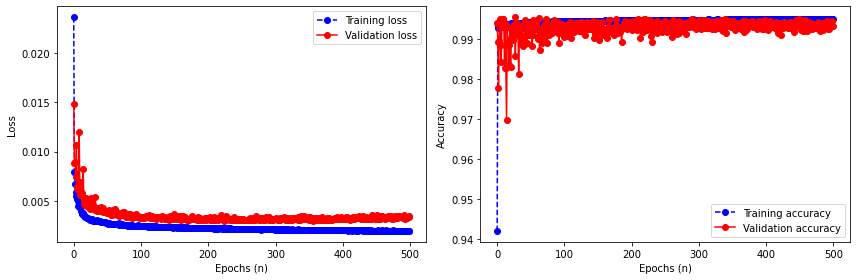

In [7]:
# Print training parameters, to archive them together with the notebook output.

time_sequence_start = datetime.datetime.now()

print("Timestamp for saved files: {}".format(save_timestamp))
print("\nTraining parameters")
print("Number of epochs:    {}".format(num_epochs))
print("Step size maximum:   {}".format(max_learning_rate))
print("Step size decay:     {}".format(learning_rate_decay))
print("Batch size:          {}".format(batch_size))
print("Regularization rate: {}".format(regularization_rate))
print("")
print("Saving validation predictions in: {}".format(val_data_fullpath))
print("Saving models in:                 {}".format(models_save_fullpath))

# ROC data will be saved in these containers

val_best_metrics    = dict()
val_fuzzy_metrics   = dict()
val_aurocs          = np.zeros(num_validation_rounds)
val_best_thresholds = np.zeros(num_validation_rounds)

# Perform validation rounds

for val_round_index in range(num_validation_rounds):
    
    # Prepare data arrays
    
    train_ultrasound_data = np.zeros(
        [0,
         ultrasound_arrays_by_patients[0].shape[1],
         ultrasound_arrays_by_patients[0].shape[2],
         ultrasound_arrays_by_patients[0].shape[3]])
    
    train_segmentation_data = np.zeros(
        [0,
         segmentation_arrays_by_patients[0].shape[1],
         segmentation_arrays_by_patients[0].shape[2],
         segmentation_arrays_by_patients[0].shape[3]])
    
    val_ultrasound_data = np.zeros(
        [0,
         ultrasound_arrays_by_patients[0].shape[1],
         ultrasound_arrays_by_patients[0].shape[2],
         ultrasound_arrays_by_patients[0].shape[3]])
    
    val_segmentation_data = np.zeros(
        [0,
         segmentation_arrays_by_patients[0].shape[1],
         segmentation_arrays_by_patients[0].shape[2],
         segmentation_arrays_by_patients[0].shape[3]])
    
    for patient_index in range(n_patients):
        if patient_index not in validation_schedule_patient[val_round_index]:
            train_ultrasound_data = np.concatenate((train_ultrasound_data,
                                                    ultrasound_arrays_by_patients[patient_index]))
            train_segmentation_data = np.concatenate((train_segmentation_data,
                                                      segmentation_arrays_by_patients[patient_index]))
        else:
            val_ultrasound_data = np.concatenate((val_ultrasound_data,
                                                 ultrasound_arrays_by_patients[patient_index]))
            val_segmentation_data = np.concatenate((val_segmentation_data,
                                                   segmentation_arrays_by_patients[patient_index]))
    
    n_train = train_ultrasound_data.shape[0]
    n_val = val_ultrasound_data.shape[0]
    
    print("\n*** Leave-one-out round # {}".format(val_round_index))
    print("    Training on {} images, validating on {} images...".format(n_train, n_val))
    
    val_segmentation_data_onehot = tf.keras.utils.to_categorical(val_segmentation_data, num_classes)
    
    # Create and train model
    
    model = unet.segmentation_unet(ultrasound_size, num_classes, filter_multiplier, regularization_rate)
    
    model.compile(
        optimizer=tf.keras.optimizers.Adam(lr=max_learning_rate, decay=learning_rate_decay),
        loss=unet.weighted_categorical_crossentropy(class_weights),
        metrics=["accuracy"]
    )
    
    # model.summary()
        
    training_generator = generator.UltrasoundSegmentationBatchGenerator(
        train_ultrasound_data,
        train_segmentation_data[:, :, :, 0],
        batch_size,
        (ultrasound_size, ultrasound_size),
        max_shift_factor=max_shift_factor,
        min_zoom_factor=min_zoom_factor,
        max_zoom_factor=max_zoom_factor,
        max_rotation_angle=max_rotation_angle
    )
        
    training_time_start = datetime.datetime.now()
    
    if n_val > 0:
        training_log = model.fit_generator(
            training_generator,
            validation_data=(val_ultrasound_data, val_segmentation_data_onehot),
            epochs=num_epochs,
            verbose=0)
    else:
        training_log = model.fit_generator(training_generator, epochs=num_epochs, verbose=0)
    
    training_time_stop = datetime.datetime.now()
    
    # Pring training log
    
    print("  Training time: {}".format(training_time_stop-training_time_start))
    
    # Plot training loss and metrics
    
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 4))
    
    axes[0].plot(training_log.history['loss'], 'bo--')
    if n_val > 0:
        axes[0].plot(training_log.history['val_loss'], 'ro-')
    axes[0].set(xlabel='Epochs (n)', ylabel='Loss')
    if n_val > 0:
        axes[0].legend(['Training loss', 'Validation loss'])
    
    axes[1].plot(training_log.history['accuracy'], 'bo--')
    if n_val > 0:
        axes[1].plot(training_log.history['val_accuracy'], 'ro-')
    axes[1].set(xlabel='Epochs (n)', ylabel='Accuracy')
    if n_val > 0:
        axes[1].legend(['Training accuracy', 'Validation accuracy'])
    
    fig.tight_layout()
    
    # Archive trained model with unique filename based on notebook name and timestamp
    
    model_file_name = this_notebook_name + "_model-" + str(val_round_index) + "_" + save_timestamp + ".h5"
    model_fullname = os.path.join(models_save_fullpath, model_file_name)
    model.save(model_fullname)
    
    # Predict on validation data
    
    if n_val > 0:
        y_pred_val  = model.predict(val_ultrasound_data)

        # Saving predictions for further evaluation

        val_prediction_filename = save_timestamp + "_prediction_" + str(val_round_index) + ".npy"
        val_prediction_fullname = os.path.join(val_data_fullpath, val_prediction_filename)
        np.save(val_prediction_fullname, y_pred_val)

        # Validation results

        vali_metrics_dicts, vali_best_threshold_index, vali_area = evaluation_metrics.compute_roc(
            roc_thresholds, y_pred_val, val_segmentation_data, acceptable_margin_mm, mm_per_pixel)

        val_fuzzy_metrics[val_round_index] = evaluation_metrics.compute_evaluation_metrics(
            y_pred_val, val_segmentation_data, acceptable_margin_mm, mm_per_pixel)

        val_best_metrics[val_round_index]    = vali_metrics_dicts[vali_best_threshold_index]
        val_aurocs[val_round_index]          = vali_area
        val_best_thresholds[val_round_index] = roc_thresholds[vali_best_threshold_index]
    
    # Printing total time of this validation round
    
    print("\nTotal round time:  {}".format(datetime.datetime.now() - training_time_start))
    print("")


time_sequence_stop = datetime.datetime.now()

print("\nTotal training time:   {}".format(time_sequence_stop - time_sequence_start))


In [8]:
# Arrange results in tables

metric_labels = [
    "AUROC",
    "best thresh",
    "best TP",
    "best FP",
    "best recall",
    "best precis",
    "fuzzy recall",
    "fuzzy precis",
    "fuzzy Fscore"
]

results_labels = []

for label in metric_labels:
    results_labels.append("Vali " + label)

results_df = pd.DataFrame(columns = results_labels)

for i in range(num_validation_rounds):
    if i in val_best_metrics.keys():
        results_df.loc[i] = [
            val_aurocs[i],
            val_best_thresholds[i],
            val_best_metrics[i][evaluation_metrics.TRUE_POSITIVE_RATE],
            val_best_metrics[i][evaluation_metrics.FALSE_POSITIVE_RATE],
            val_best_metrics[i][evaluation_metrics.RECALL],
            val_best_metrics[i][evaluation_metrics.PRECISION],
            val_fuzzy_metrics[i][evaluation_metrics.RECALL],
            val_fuzzy_metrics[i][evaluation_metrics.PRECISION],
            val_fuzzy_metrics[i][evaluation_metrics.FSCORE]
        ]

display(results_df)

print("\nAverages")

results_means_df = results_df.mean()
display(results_means_df)

,Vali AUROC,Vali best thresh,Vali best TP,Vali best FP,Vali best recall,Vali best precis,Vali fuzzy recall,Vali fuzzy precis,Vali fuzzy Fscore
0,0.990548,0.02,0.978888,0.024263,0.978888,0.146686,0.744071,0.326686,0.454029



Averages


Vali AUROC           0.990548
Vali best thresh     0.020000
Vali best TP         0.978888
Vali best FP         0.024263
Vali best recall     0.978888
Vali best precis     0.146686
Vali fuzzy recall    0.744071
Vali fuzzy precis    0.326686
Vali fuzzy Fscore    0.454029
dtype: float64

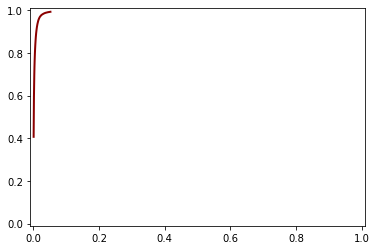

In [9]:
# Print the last ROC curve for visual verification that we catch the optimal point

n = len(roc_thresholds)

roc_x = np.zeros(n)
roc_y = np.zeros(n)

for i in range(n):
    roc_x[i] = vali_metrics_dicts[i][evaluation_metrics.FALSE_POSITIVE_RATE]
    roc_y[i] = vali_metrics_dicts[i][evaluation_metrics.SENSITIVITY]
    # print("Threshold = {0:4.2f}  False pos rate = {1:4.2f}  Sensitivity = {2:4.2f}"
    #       .format(roc_thresholds[i], roc_x[i], roc_y[i]))

    
plt.figure()
plt.ylim(-0.01, 1.01)
plt.xlim(-0.01, 1.01)
plt.plot(roc_x, roc_y, color='darkred', lw=2)

In [10]:
# Save results table

csv_filename = this_notebook_name + "_" + save_timestamp + ".csv"
csv_fullname = os.path.join(results_save_fullpath, csv_filename)
results_df.to_csv(csv_fullname)

print("Results saved to: {}".format(csv_fullname))

Results saved to: c:\Data\SagittalSpineSegmentationStudy\SavedResults\SagittalSpineSegmentationStudy-TF2_2021-01-30_20-28-46.csv


IndexError: index 391 is out of bounds for axis 0 with size 360

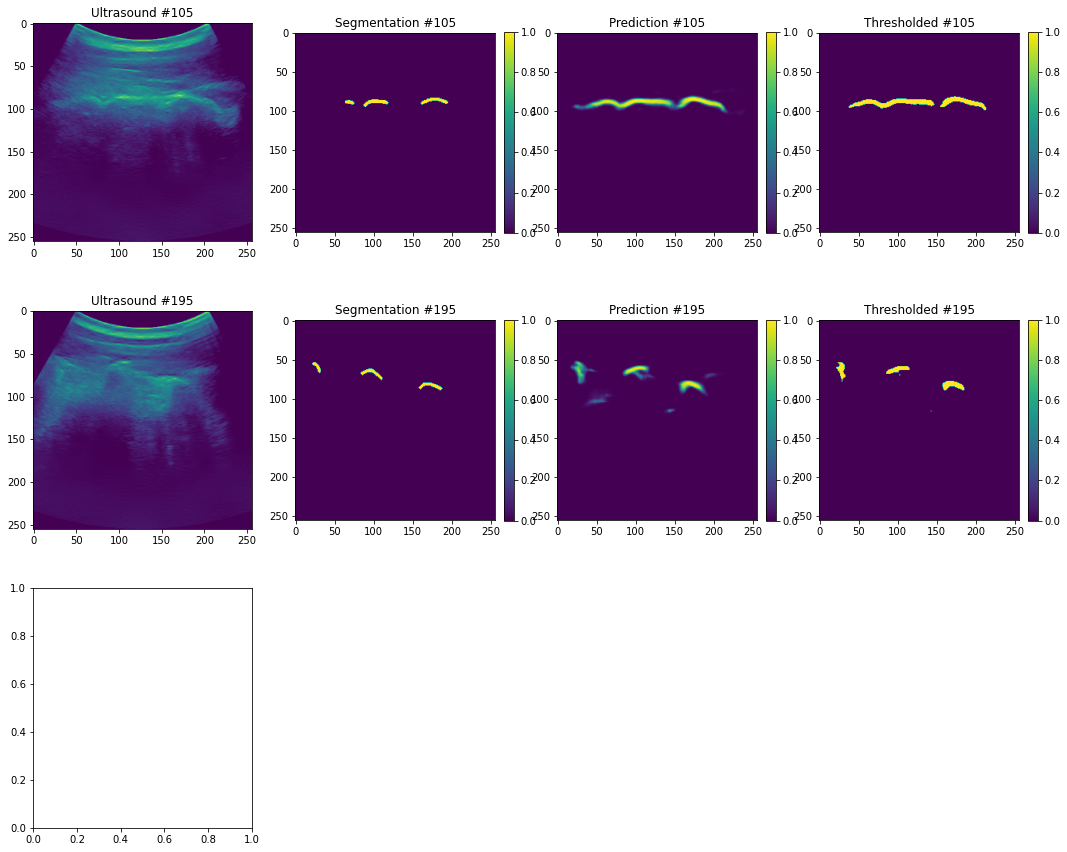

In [11]:
# Display sample results

num_vali = val_ultrasound_data.shape[0]
num_show = 3
if num_vali < num_show:
    num_show = 0
num_col = 4
    
indices = [i for i in range(num_vali)]
sample_indices = sample(indices, num_show)
sample_indices = [0, 4, 6]

threshold = 0.5

# Uncomment for comparing the same images
# sample_indices = [105, 195, 391, 133, 142]

fig = plt.figure(figsize=(18, num_show*5))
for i in range(num_show):
    a0 = fig.add_subplot(num_show, num_col, i*num_col+1)
    img0 = a0.imshow(np.flipud(val_ultrasound_data[sample_indices[i], :, :, 0].astype(np.float32)))
    a0.set_title("Ultrasound #{}".format(sample_indices[i]))
    a1 = fig.add_subplot(num_show, num_col, i*num_col+2)
    img1 = a1.imshow(np.flipud(val_segmentation_data_onehot[sample_indices[i], :, :, 1]), vmin=0.0, vmax=1.0)
    a1.set_title("Segmentation #{}".format(sample_indices[i]))
    c = fig.colorbar(img1, fraction=0.046, pad=0.04)
    a2 = fig.add_subplot(num_show, num_col, i*num_col+3)
    img2 = a2.imshow(np.flipud(y_pred_val[sample_indices[i], :, :, 1]), vmin=0.0, vmax=1.0)
    a2.set_title("Prediction #{}".format(sample_indices[i]))
    c = fig.colorbar(img2, fraction=0.046, pad=0.04)
    a3 = fig.add_subplot(num_show, num_col, i*num_col+4)
    img3 = a3.imshow((np.flipud(y_pred_val[sample_indices[i], :, :, 1]) > threshold), vmin=0.0, vmax=1.0)
    c = fig.colorbar(img3, fraction=0.046, pad=0.04)
    a3.set_title("Thresholded #{}".format(sample_indices[i]))

In [ ]:
# Save notebook so all output is archived by the next cell

from IPython.display import Javascript
script = '''
require(["base/js/namespace"],function(Jupyter) {
    Jupyter.notebook.save_checkpoint();
});
'''
Javascript(script)

In [12]:
# Export HTML copy of this notebook

notebook_file_name = this_notebook_name + "_" + save_timestamp + ".html"
notebook_fullname = os.path.join(notebooks_save_fullpath, notebook_file_name)

os.system("jupyter nbconvert --to html " + this_notebook_name + " --output " + notebook_fullname)
print("Notebook saved to: {}".format(notebook_fullname))

Notebook saved to: c:\Data\SagittalSpineSegmentationStudy\SavedNotebooks\SagittalSpineSegmentationStudy-TF2_2021-01-30_20-28-46.html
